# The reproduction of literarure:Computational Rationalization: The Inverse Equilibrium Problem

## Abstract:

Modeling the purposeful behavior of imperfect agents from a small number of observations is a challenging task. When restricted to the single-agent decision-theoretic setting, inverse optimal control techniques assume that observed behavior is an approximately optimal solution to an unknown decision problem. These techniques learn a utility function that explains the example behavior and can then be used to accurately predictor imitate future behavior in similar observedor unobserved situations.In this work, we consider similar tasks in competitive and cooperative multi-agent domains. Here, unlike single-agent settings, a player cannot myopically maximize its reward — it must speculate on how the other agents may act to influence the game’s outcome. Employing the game-theoretic notion of regret and the principle of maximum entropy, we introduce a technique for predicting and generalizing behavior, as well as recovering a reward function in these domains.

## Theory:

### Problem description:

As input, we observe a sequence of outcomes, ${a_{m}}_{m=1}^{M}$, sampled from σ, the true behavior. We denote the empirical distribution of this sequence, $\tilde{σ}$, the demonstrated behavior. We aim to learn a predictive behavior distribution, $\hat{σ}$ from these demonstrations. 

### Solution:

Instantaneous regret measures how much a player would benefit from a particular modification function when the coordination device draws joint-action a,: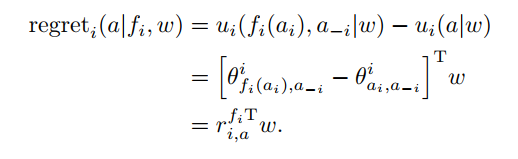

The modification function can be a switch modificaiton function, for instance: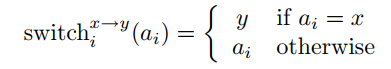 substitutes action y for recommendation x.

Players do not have knowledge of the complete jointaction; thus, each must reason about the expected regret with respect to a modification function: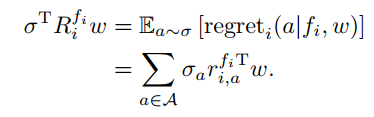

The expected regret with respect to Φ and outcome distribution σ is: 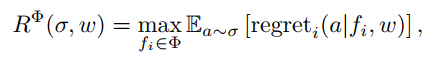 and the regret can be thought of as a substitute for utility when assessing the optimality of behavior in multi-agent settings.

The predicted behavior distribution should satisfy the constrints of rationality assumptions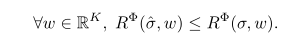  

Unfortunately, a direct translation of the strong rationality requirement into constraints on the distribution $\hat{σ}$ leads to a non-convex optimization problem as it involves products of varying utility vectors and the behavior to be estimated. Fortunately, however, we can provide an equivalent concise convex description of the constraints on $\hat{σ}$ that ensures any feasible distribution satisfies strong rationality: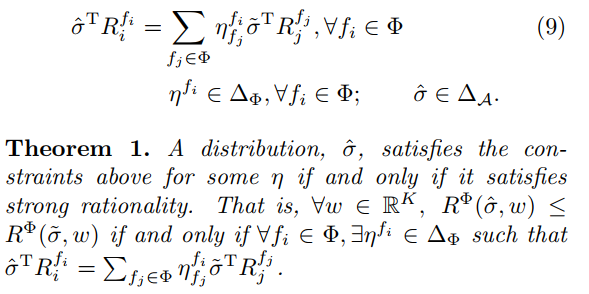The proof of Theorem 1 is provided in the Appendix.

We first consider prediction of the demonstrated behavior using the principle of maximum entropy and our strong rationality condition 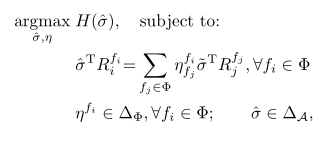

Until now, we have considered the problem of identifying behavior in a single game. We note, however, that our approach enables behavior transfer to games equipped with the same features. We denote this unobserved game as $ \bar{\Gamma}$. As with prediction, to develop a technique for behavior transfer we assume a link between regret and the agents’ preferences across the known space of possible preferences. Furthermore, we assume a relation between the regrets in both games.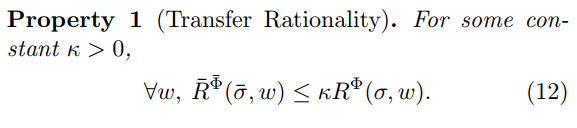 

As we are not privileged to know κ and this property is not guaranteed to hold, we introduce a slack variable to allow for violations of the strong rationality constraints to guaranteeing feasibility. The corresponding mathematical program is :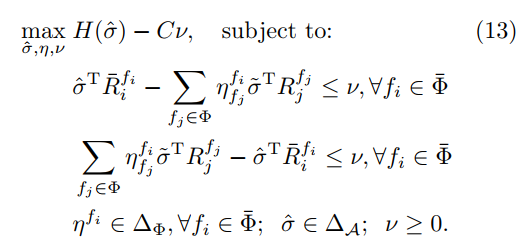 In the above formulation, C > 0 is a slack penalty parameter, which allows us to choose the trade-off between obeying the rationality constraints and maximizing the entropy. Additionally, we have omitted κ above by considering it intrinsic to R.

The dual of the transfer program is :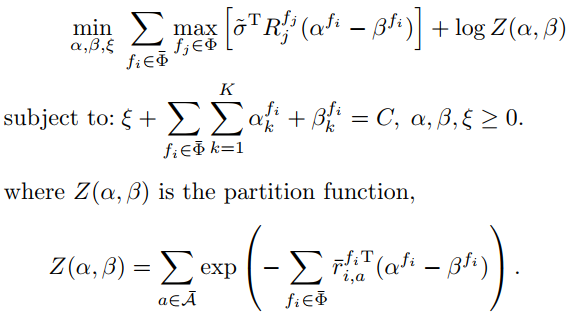

For C > 0, the dual's feasible set has non-empty interior and is bounded. Therefore, by Slater's condition, strong duality holds – there is no duality gap. In particular, we can use a dual solution to recover $\hat{σ}$.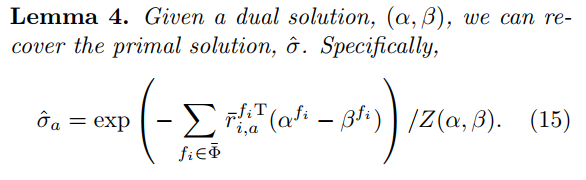

Algorithm 1 employs exponentiated gradient descent (Kivinen & Warmuth, 1995) to find an optimal dual solution.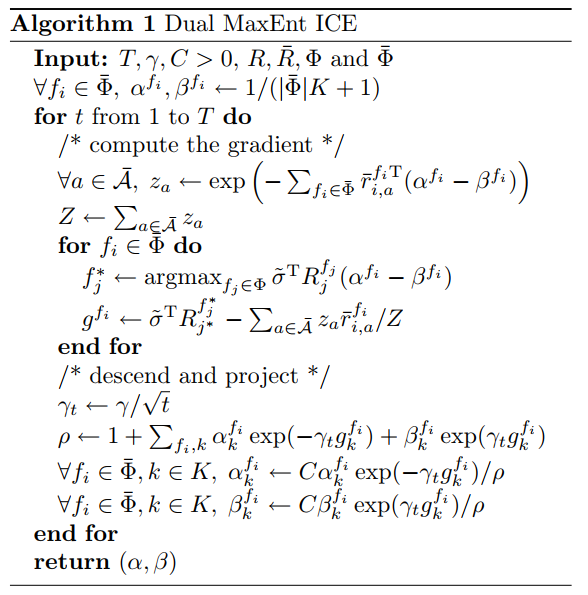

Prediction error (log-loss) as a function of number of observations：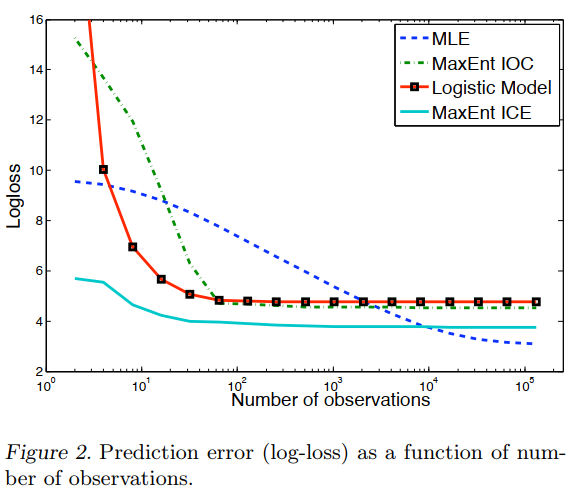

## Experiment description:

A simple routing game shown in Figure 1. Seven drivers in this game choose how to travel home during rush hour after a long day at the office. The different road segments have varying capacities, visualized by the line thickness in the figure, that make some of them more or less susceptible to congestion or to traffic accidents. Upon arrival home, each driver records the total time and distance they traveled, the gas that they used, and the amount of time they spent stopped at intersections or in traffic jams – their utility features. 

## Parameter setting:

In figure 1, Black lines represent roads, and each road contains several road segments. The index of each road segment is shown in the figure below. The capacities of road segments are:[1,1,2,3,2,5,2,3,2,2]. A road can be expressed by the sequence of segments it contains. For instance, road1 = [1,3,4,5,7,9],denoting that road1 contains road segments 1,3,4,5,7 and 9. Similiarly, road2 = [1,3,4,6,8,10], road3 = [2,4,5,7,9], road4 = [2,4,6,8,10]. We set the length of each road segment to be 20KM.

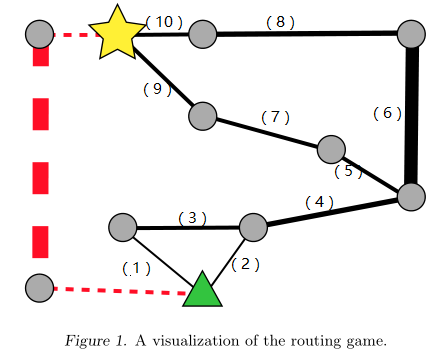

## Code: Part I Generating True Behavior Distribution

1. Import necessary pockages and modules

In [1]:
import numpy as np
from sklearn import linear_model       
import matplotlib.pyplot as plt
import scipy.stats as stats
import operator
import random
import math

2. Define the parameters. Note that, since the variable indexs count from 0, the index of both roads and road segments discussed above should minus 1. Parameter yibusilo is parameter ε of ε-correlated equilibrium: $R^{\Phi ^{swap}}(\sigma ,\omega ^{*})\leq \varepsilon $, where R represents the expected regret with respect to Φ and outcome distribution σ. Parameter omega represent the preference of drivers corresponding to the utility features [the total travle time , the total travel distance, the gas, and the amount of jam time] : they all prefer mainly to minimize their travel time, but were also slightly concerned with gas usage.

In [2]:
route_num = 4 #路径数
driver_num = 7 #司机数
global route_seg_length #每段公路长20公里
route_seg_length= 20 #每段公路长20公里

yibusilo = 0.5

route =np.array([[0,2,3,4,6,8],[0,2,3,5,7,9],[1,3,4,6,8],[1,3,5,7,9]])
#每个路径对应的路段

route_seg_wid=np.array([1,1,2,3,2,5,2,3,2,2])
#每个路段的路宽

omega = [10,0,2,0]#偏好设置

3. Based on the speed limitaion policy in China, we define a function to calculate the car's speed on different road segments. If the number of lanes of a road segment(the capacity) is 1, cars travel in a speed of 50km/h. If the number of lanes is 2, cars can travel at 70km/h. If the road segment contains more than 3 lanes, then this segment can be called as a highway, where cars can travel at 120km/h.

In [5]:
def route_speed_limit(route_wid):
    #输入道路宽度，输出限速：单车道限速50，双车道70，三车道及以上限速120
    speed_limit = 50
    if route_wid == 2:
        speed_limit = 70
    elif route_wid  >= 3:
        speed_limit = 120
    return speed_limit

4. We use the linear model to estimate the the relationship between the oil consumption and the velacity of the car.

In [4]:
X=[[120],[90],[60],[30]] #利用线性回归训练油耗模型
y=[[7.81],[5.86],[4.12],[4.10]]
model = linear_model.LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

5. Define the swap function f.

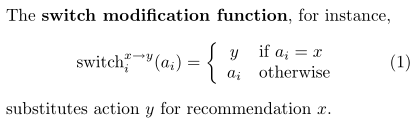

In [6]:
func_f = np.zeros((route_num,route_num-1),dtype = int)
for i in range(route_num):
    k = 0
    for j in range(route_num):     
        if j != i :
            func_f[i][k] = j
            k += 1

func_f_val = np.zeros((len(func_f)*len(func_f[0]),1,2),dtype=int) #把func 变为 12* 1*2 的数组整理起来
i = 0
for j in range(len(func_f)):
    for k in range(len(func_f[j])):
        route_bef = j
        route_aft = func_f[j][k]
        func_f_val[i] = [route_bef,route_aft]
        i += 1

6. For convenience's sake, we use an int to represent the outcome or the joint-actions of all the drivers. For example, we use 123 to represent the outcome [1,3,2,3] which means that driver0 chooses road1, driver1 chooses road3... Apparently, it is an conversion between decimal number and quaternary number in this work. So we define two functions:decode and encode to represent the convertion from decimal number to quaternary number and the convertion from quaternary number to decimal number,respectively.

In [8]:
def ten_four(n,result=[]):
    #将十进制数据变为一组四进制数组，如123->[1,3,2,3],意味着123的四进制表示为1323
    multiple = n//route_num
    reminder = n%route_num
    result.insert(0,reminder)
    if (multiple!=0):
        ten_four(multiple,result)
    return result

def decode(n):
    #状态空间解码函数，将一个整数映射为对应的路径例如：123-> [0,0,0,1,3,2,3]，分别对应7个司机对于四种路径的选择
    action=ten_four(n,[])
    while(len(action) < driver_num):
        action.insert(0,0)
    return np.array(action) 

def encode(list):
    #状态空间解码函数，将对应的路径映射为一个整数例如： [0,0,0,1,3,2,3]->123
    n=0
    for i in range(len(list)):
        n += list[i]*(route_num**(len(list)-i-1))
    return n

7. Define a function to express the represent the relation the joint-actions and the number of cars in each road segment. For example action_route_seg([0,0,0,0,0,0,0]) = [7,0,7,7,7,0,7,0,7,0]

In [9]:
def action_route_seg(act):
    #定义由行为到每个路段中车流量的映射，例如[0,0,0,0,0,0,0]->[7,0,7,7,7,0,7,0,7,0]
    cars_in_seg = np.zeros(10,dtype=int)
    for i in range(len(act)):
        for j in range(len(route[act[i]])) :
            cars_in_seg[route[act[i]][j]] += 1
    return cars_in_seg

8. Define functions to calculate the utility features. The total travel distance equals to the sum of the length of road segments contained by the road. The totla time equals to the sum of the travel time and the jam time. The travel time can be calculated by the total distance divided by speed. Whenever cars in the certain road segment are more than the capacity of this segment, jam occurs. For every extra car, the jam time adds 3min. When the cars are in traffic jam, they consume oil as well. For every 5min waiting in a traffic jam, a car consumes 0.15 litre oil. 

In [10]:
def oil_calculate(v,b_time):
    #根据车速以及等待时间计算油耗
    oil_run = model.predict([[v]])[0][0]*route_seg_length/100
    oil_block = 12*0.15*b_time #等待5分钟等于行驶1公里，按每百公里15公升由计算
    return oil_block+oil_run
     
def route_seg_theta(cars_num,route_wid):
    #根据路段宽度以及车流量，计算每辆车的通过时间，通过路程，消耗燃油量，堵塞时间

    velocity = route_speed_limit(route_wid)
    block_time = 0
    if cars_num > route_wid:
        velocity = route_speed_limit(route_wid)*route_wid/cars_num
        block_time = (cars_num-route_wid)*3 #等待时间为3分钟的倍数
    
    run_time = 60*(route_seg_length/velocity) + block_time
    #print(run_time)
    oil_consumption = oil_calculate(velocity,block_time)
    output = np.array([run_time,route_seg_length,oil_consumption,block_time])
    
    return output

def theta(act,i,outcome_feature_max,outcome_feature_min):
    #定义theta(a,i)对于行为a，中的第i个决策者的outcome feature
    cars_num = action_route_seg(act)
    action_i = act[i]#第i个决策者的决策
    route_seg_i = route[action_i]#该决策路径对应的路段
    outcome_feature = np.zeros(4,dtype=float)
    for j in range(len(route_seg_i)):#遍历该决策中所有路段
        name_route_seg_i_j = route_seg_i[j] 
        cars_seg = cars_num[name_route_seg_i_j]
        outcome_feature += route_seg_theta(cars_seg,route_seg_wid[name_route_seg_i_j])

    for k in range(K_val):
        if outcome_feature[k] > outcome_feature_max[k]:
            outcome_feature_max[k] = outcome_feature[k]

        if outcome_feature[k] < outcome_feature_min[k]:
            outcome_feature_min[k] = outcome_feature[k]
    #print(outcome_feature,outcome_feature_max,outcome_feature_min)
    return outcome_feature,outcome_feature_max,outcome_feature_min

9. Define the function of regret of a given switch function. And then, we define and calculate the matrix which contains the regret of each action given a specific switch function. 

In [11]:
def cal_r(a,f,i,theta_0):
    #计算r(ia,fi)
    action_before = decode(a)
    action_after = action_before.copy()
    if action_before[i] == f[0]:
        action_after[i] = f[1]
        a_new = encode(action_after)
        reg = theta_0[a_new][i] - theta_0[a][i]
    else :
        reg = np.zeros(K_val)
    #print(reg)
    return reg


def MaxMinNormalization(x,Max,Min):
	x = (x - Min) / (Max - Min)
	return x


K_val = 4
e_val = 0.5 #对偶问题最优性的松弛
a_val = route_num**driver_num

outcome_feature_max_val = np.zeros(4,dtype=float)
outcome_feature_min_val = 1e6*np.ones(4,dtype=float)

theta_matrix = np.zeros((a_val,driver_num,K_val),dtype=float)
for a in range(a_val):
    action = decode(a)
    for i in range(driver_num):
        theta_matrix[a][i],outcome_feature_max_val,outcome_feature_min_val = theta(action,i,outcome_feature_max_val,outcome_feature_min_val)
        #print(outcome_feature_max_val,outcome_feature_min_val)
    
for a in range(a_val):
    for i in range(driver_num):
        theta_matrix[a][i] = MaxMinNormalization(theta_matrix[a][i],outcome_feature_max_val,outcome_feature_min_val)

print(theta_matrix[15756][0])






R = np.zeros((driver_num,len(func_f_val),a_val,K_val),dtype=float)


for i in range(driver_num):
    for j in range(len(func_f_val)):
        f = func_f_val[j][0]
        for a in range(a_val):            
            
            R[i][j][a] = cal_r(a,f,i,theta_matrix)


np.save('R_8players.npy',R)
print('r',R[0][0][0])

11. Calculate the ε-correlated equilibrium distribution to be the true behaviour distribution.

In [ ]:
omega = [-10,0,-2,0]#偏好设置

code = np.arange(0,route_num**driver_num,1)
distribution_0 = stats.norm.pdf(code,route_num**driver_num//2,route_num**driver_num//6)
minus = 1-sum(distribution_0)
distribution_0 += minus/len(distribution_0)   





    return n


def equilibrium_det(distribution):
    #判断一个分布是否符合相关均衡，不符合则更新分布
       
    for i in range(fai_cap):
        i_val = i//len(func_f_val)
        f = i%len(func_f_val)
        f_fun = func_f_val[f][0]  
        except_reg = distribution.dot(Regret_val[i_val][f].T)
        #print(Regret_val[i_val][f][15816])
        if except_reg > yibusilo:
            print('fail to be equilibrium',i_val,f_fun,except_reg)
            decline = 0.0
            num = 0
            for j in range(len(distribution)):
                
                if Regret_val[i_val][f][j] > 0:
                    decline += distribution[j]/10
                    distribution[j] -=  distribution[j]/10                    
                else:
                    num += 1
            for j in range(len(distribution)):
                if Regret_val[i_val][f][j] <= 0:
                    distribution[j] +=  decline/num                                             
            return  False,distribution
    print('equilibrium')
    return True,distribution      

print(func_f)


t = 0
while(1):
   TF,distribution_0 = equilibrium_det(distribution_0)
   
   if TF == True :
       break



aa = np.array(distribution_0)
np.save('distribution_8players_'+str(yibusilo)+'.npy',aa)
print(sum(aa))
print(aa.max())

## Part II Predicting Behavior Distribution

We take the slack penalty parameters into consideration. Then the corresponding mathematical program is 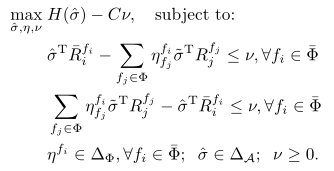 Unfortunately, this mathematical program cannot be solved easily, so the author employs exponentiated gradient descent (Kivinen & Warmuth, 1995) to find an optimal dual solution, which is shown below.

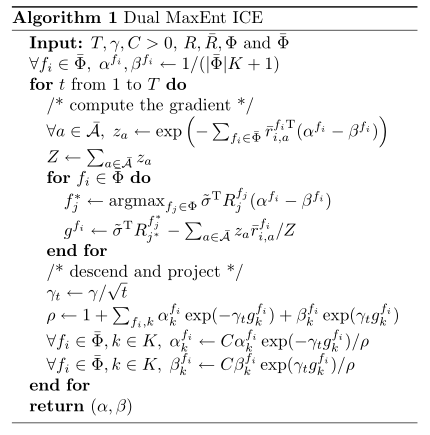

where $\gamma = \sqrt{2log\left |  \bar{\Phi} \right | K}/ \Delta$ Note that, in this numerical experiment, the unobserved game $ \bar{\Gamma}$ is the same as the observed game $ \Gamma$.

## 2. Code of Part II

1. Using roulette sampling to generate demonstrated distribution.

In [ ]:
def RWS(distribution):
    #轮盘赌采样
    rand = random.random()
    pos = 0
    for i in range(len(distribution)):
        pos += distribution[i]
        if (rand <= pos):
            return i
        
distribution_true = np.load('distribution_1.npy') #真实分布
sample_num = 7 #采样数

distribution_true = np.load('distribution_712players_1e-06.npy') #真实分布


distribution_obt = np.zeros(len(distribution_true),dtype=float) 
for i in range(sample_num):#采样，并记录分布
    rand_code = RWS(distribution_true)
    distribution_obt[rand_code] += 1.0 
distribution_obt /= sample_num


print(distribution_obt[distribution_obt!=0])

2. Use the algorithm1 showm above to generate the predicted distribution and evaluate the distribution using log-loss method:$-\sum _{a \in A}\sigma _{a}log \hat{\sigma}_{a}$. To prevent the number in log() from being 0, we add the probability of each outcome to 1e-15. 

In [ ]:
sample_num = 2000#采样数
T_val = 1000
C_val = 12#松弛系数，用于权衡强理性约束以及最大熵约束

K_val = 4

def cal_L(alpha,beta,R,distribution,fai_cap):
    "calculate L(alpha,beta)"
    L = 0.0
    for i in range(fai_cap):
        arg_max_val = -50000000          
        for j in range(fai_cap):
            j_val = j//len(func_f_val)
            j_f = j%len(func_f_val)            
            R_j = R[j_val][j_f]            
            arg_max_try = distribution.dot(R_j).dot((alpha[i]-beta[i]).T)            
            if arg_max_try > arg_max_val:
                arg_max_val = arg_max_try          
        L += arg_max_val
    
    sum_val_1 = 0.0
    for a in range(len(distribution)):
        sum_val = 0.0
        for i in range(fai_cap):
            i_val = i//len(func_f_val)
            f = i%len(func_f_val)                  
            reg_val = R[i_val][f][a]                          
            sum_val -= reg_val.dot(alpha[i]-beta[i])
        
        sum_val_1 += math.exp(sum_val)
    L += math.log(sum_val_1) -1 
    return L

R = np.load('R_7players.npy') #R
#R = np.load('R.npy') #R

print(R.shape)

deta = R.max() #计算deta用于后续计算

fai_cap = len(func_f_val) *driver_num
print(fai_cap)

gamma_val = math.sqrt(2*math.log(fai_cap*K_val)) / deta #计算梯度下降步长gamma

print('T max:',deta,gamma_val)
#gamma_val = 3

print('T,C,gamma,sample',T_val,C_val,gamma_val,sample_num)
alpha_val = np.zeros((fai_cap,K_val),dtype=float)
beta_val = np.zeros((fai_cap,K_val),dtype=float)
for i in range(fai_cap):
    alpha_val[i] = 1/(C_val*4*fai_cap*np.array([1,1,1,1])+1)
    beta_val[i] = 1/(C_val*4*fai_cap*np.array([1,1,1,1])+1)
    

L_old = cal_L(alpha_val,beta_val,R,distribution_obt,fai_cap)
z = np.zeros(len(distribution_obt),dtype=float)
g = np.zeros((fai_cap,K_val),dtype=float)


for t in range(1,T_val+1):
    z_val = 0.0
    for a in range(len(distribution_obt)):
        sum_val = 0
        
        for i in range(fai_cap):
            
            i_val = i//len(func_f_val)
            f = i%len(func_f_val)
                  
            reg_val = R[i_val][f][a]
            

                
            sum_val += reg_val.dot(alpha_val[i]-beta_val[i]) 
        

        z[a]= math.exp(-1*sum_val)
        #print(z[a])
        z_val += z[a]

    for i in range(fai_cap):
        arg_max_val = -50000000              
        for j in range(fai_cap):
            i_val_j = j//len(func_f_val)
            f_j = j%len(func_f_val)
            
            R_matrix_val_j = R[i_val_j][f_j]                   

            arg_max_try = distribution_obt.dot(R_matrix_val_j).dot((alpha_val[i]-beta_val[i]).T)
            
            if arg_max_try > arg_max_val:
                arg_max_val = arg_max_try
                arg_max_j = j
            
        

        i_val_max = arg_max_j//len(func_f_val)
        f_max = arg_max_j%len(func_f_val)
        R_matrix_val = R[i_val_max][f_max]
        
        g[i] = distribution_obt.dot(R_matrix_val)
        
        i_val_i = i//len(func_f_val)
        f_i = i%len(func_f_val)
        for a in range(len(distribution_obt)) :
            g[i] -= (z[a]*R[i_val_i][f_i][a] / z_val)
        
                
                
   
   

    gamma_t_val = gamma_val / math.sqrt(t)
    rou = 1 
    for i in range(fai_cap):
        for k in range(K_val):
            rou += alpha_val[i][k]*math.exp(-1*gamma_t_val*g[i][k])+beta_val[i][k]*math.exp(gamma_t_val*g[i][k])
    
    for i in range(fai_cap):
        #print(g[i])
        for k in range(K_val):

            alpha_val[i][k] = (C_val*alpha_val[i][k]*math.exp(-1*gamma_t_val*g[i][k]))/rou
            
            beta_val[i][k] = (C_val*beta_val[i][k]*math.exp(gamma_t_val*g[i][k]))/rou

            
        #print(alpha_val[i]-beta_val[i])
    
    

    '''
    for i in range(fai_cap):
        #print(g[i])
        alpha_val[i] -= yita*g[i]
            
        beta_val[i] += yita*g[i]

        #print(alpha_val[i]-beta_val[i])
    '''

    
    
    if t%100 == 0:
        L_new = cal_L(alpha_val,beta_val,R,distribution_obt,fai_cap)
        print(t,L_new-L_old)
    #L_new = cal_L(alpha_val,beta_val,R,distribution_obt,fai_cap)
    #print(t,L_new-L_old)
    

    #print(t)
    #if abs(L_new-L_old) < tol:
    #    break



z_val = 0.0

for a in range(len(distribution_obt)):
    sum_val = 0
    
    for i in range(fai_cap):
        i_val = i//len(func_f_val)
        f = i%len(func_f_val)
        reg_val = R[i_val][f][a]
        sum_val += reg_val.dot(alpha_val[i]-beta_val[i])  
                   
    z[a]= math.exp(-1*sum_val)
    z_val += z[a]
    

print(z_val)
omiga_pre = np.zeros(4,dtype=float)
pai = np.zeros(fai_cap,dtype=float)
lamb = np.zeros((fai_cap,4),dtype=float)
distribution_imi = np.zeros(len(distribution_obt),dtype=float)
for a in range(len(distribution_obt)):
    
    sum_val = 0
    
    
    for i in range(fai_cap):
        i_val = i//len(func_f_val)
        f = i%len(func_f_val)
        reg_val = R[i_val][f][a]
        lamb[i] = alpha_val[i]-beta_val[i]
        pai[i] = (np.sum(alpha_val[i])+np.sum(beta_val[i]))/C_val
        omiga_pre += pai[i]*lamb[i]
        sum_val += reg_val.dot(lamb[i])

 
    distribution_imi[a] += math.exp(-1*sum_val)/z_val
    
print(omiga_pre)

print(distribution_imi[distribution_imi!=0]) 

log_obt = 0
log_imi = 0
for act in range(len(distribution_obt)):
    
    log_obt += -1*distribution_true[act]*math.log(distribution_obt[act]+1e-15,10)
    log_imi += -1*distribution_true[act]*math.log(distribution_imi[act]+1e-15,10)
    
print(log_obt)
print(log_imi)

aaaa = np.array(distribution_imi)
np.save('distribution_imi'+str(sample_num)+'.npy',aaaa)
print(sum(aaaa))
print(np.max(aaaa))
    

        





## Result:

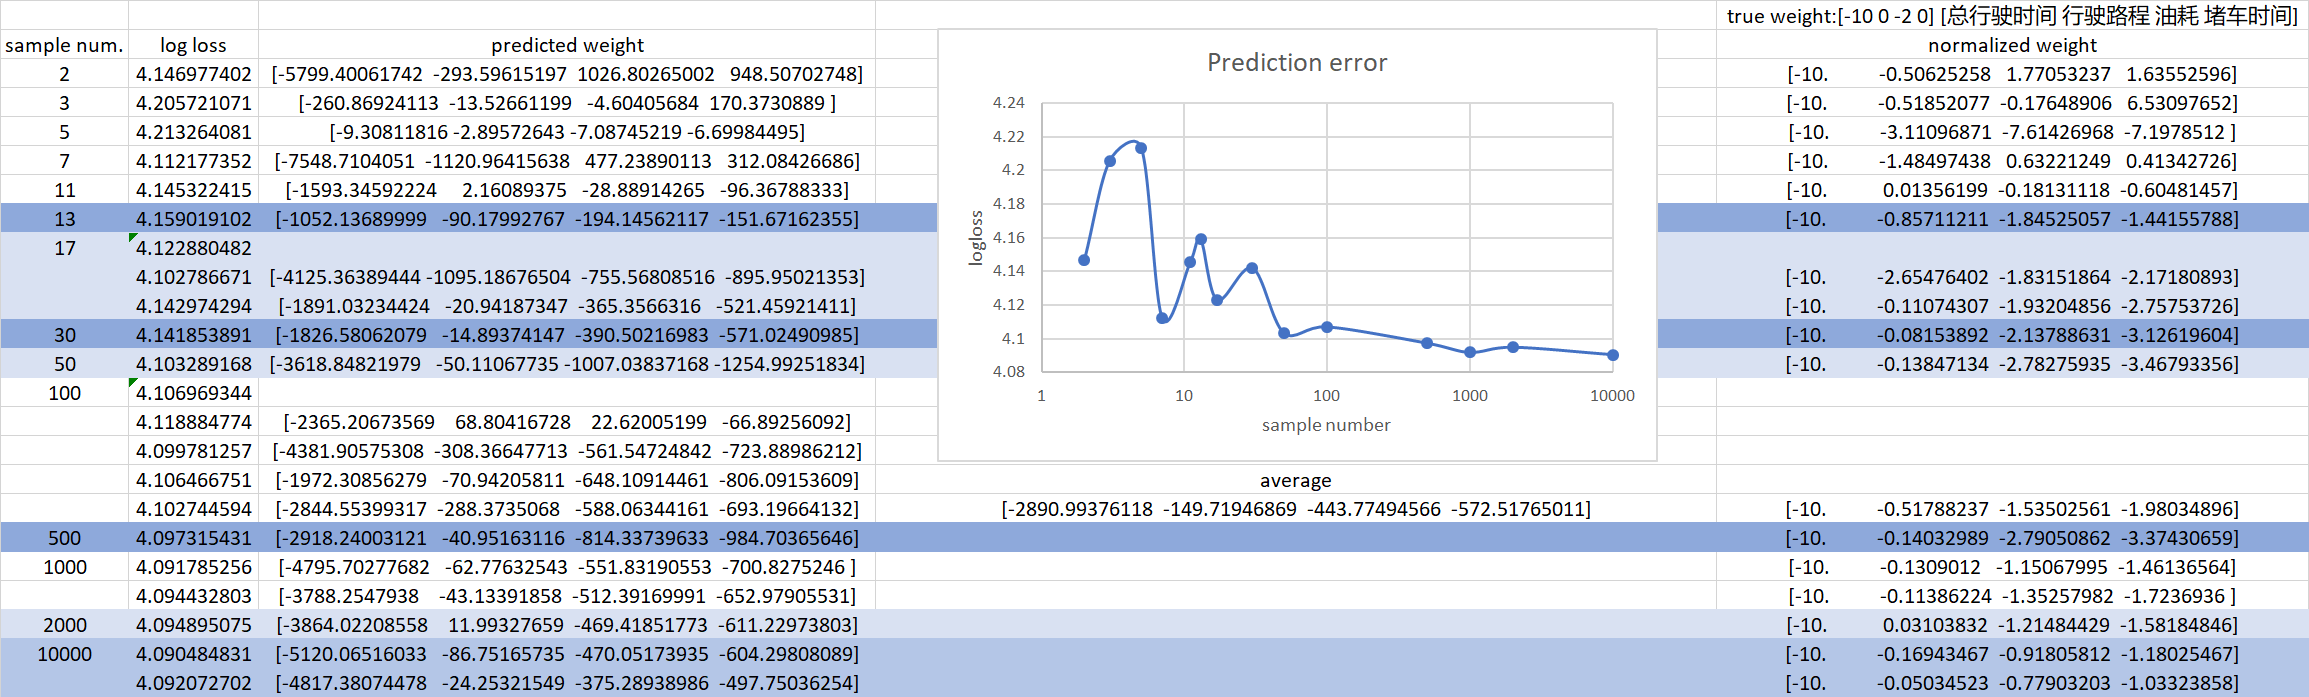

## Conclusion:

Given a limited number of samples, this algorithm can predict the distribution of joint-actions with high accuracy.  

## Appendix:

### The proof of theorem 1:
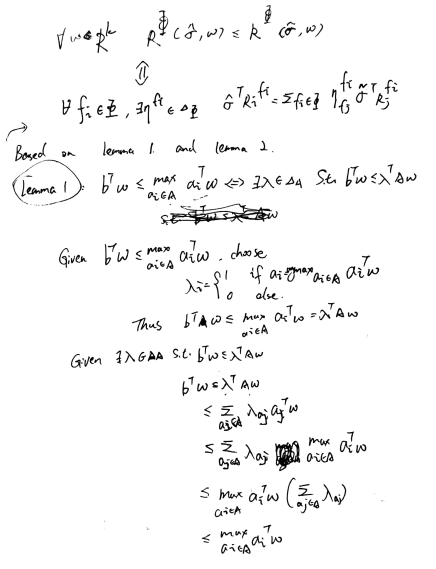

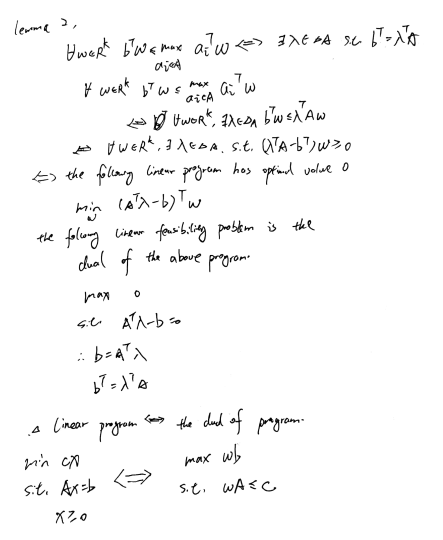

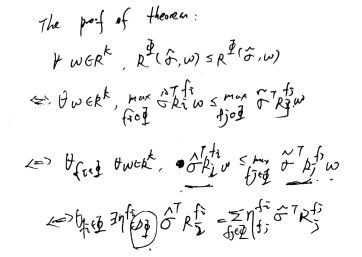